# Travelling Salesman Problem

Este é o trabalho de IA.

Grupo:
- Hendy Rodrigues F. Silva

Mat: 1510081

**Trabalho por Prof. Aragão**




### Definições

In [1]:
import numpy as np
import random
from random import *
import matplotlib.pyplot as plt

coord_x_file = open("data/coordenadasx.dat","r")
coord_y_file = open("data/coordenadasy.dat","r")

coord_x = coord_x_file.readlines()
coord_x = list(map(lambda x: int(x.strip()) ,coord_x))

coord_y = coord_y_file.readlines()
coord_y = list(map(lambda y: int(y.strip()) ,coord_y))

cities = list(zip(coord_x, coord_y))

amount_select = 300 # deve ser divisivel por 

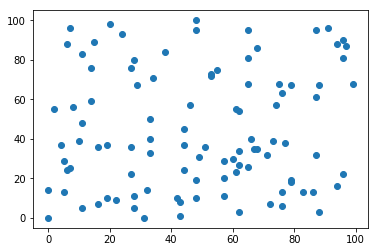

In [2]:
plt.scatter(coord_x, coord_y)

### Funções auxiliares

**Função euclidiana**
- Calcula a distância euclidiana de duas cidades.

Ela recebe tuplas no formato **(x, y)**

In [3]:
def euclidian(city_from, city_to):
    return np.sqrt((city_to[0]-city_from[0])**2 + (city_to[1]-city_from[1])**2)

**Criação de buffer**

Pega distância euclidianas e armazena num vetor ``mapCity[cidadeA][CidadeB]`` sendo que as representações da cidades são por números. (Explico abaixo)

In [4]:
mapCity = []
for city1 in cities:
    temp = []
    for city2 in cities:
        temp.append(euclidian(city1,city2))
    mapCity.append(temp)

**Função de aptidão**

A partir da variavel ``mapCity`` que contem uma matriz com as distâncias euclidianas da combinação de todas as cidades, ele pega uma lista de cidade e cria e calcula a soma de todas as cidades (no caso do problema do caixeiro viajante).

In [5]:
def fitness_func(list_cities_enum, cities):
    sum_euclidian = 0
    aux_city = -1
    for i_city in list_cities_enum:
        if aux_city != -1:
            sum_euclidian += mapCity[aux_city][i_city]
            #sum_euclidian += euclidian(cities[aux_city],cities[i_city])
        aux_city = i_city
    return sum_euclidian

**Criar população inicial**

A partir da variavel ``amount_select`` ele cria essa quantidade de cromossomos para uma população inicial do caixeiero viajante, totalmente aleatoria.

In [6]:
def create_random_paths(cities_e):
    paths = []
    
    for sel in range(0,amount_select):
        path =[i for i in range(len(cities_e))]
        shuffle(path) #function that randomize lists
        path.remove(0)
        path.insert(0,0)
        path.append(0)
        paths.append(path)
    return paths

**Montar roleta**

A partir de uma população que ele passa como parametro, ele cria um array contendo informações de cada cromossomo da população a partir de uma **tupla** nesse modelo:
#### **([ cromossomo ], função de aptidão, porcentagem acumulada)**

In [7]:
def ride_roulette(selecteds):
    values = []
    #Montar Roleta
    #auxAccu = 0
    for path in selecteds:
        fitness = fitness_func(path,cities)
        #auxAccu += fitness
        values.append((path,fitness))
        #valuesAccu.append(auxAccu)

    # Calcular porcentagens
    calcPerc = lambda x: (1/x)/sum([1/val[1] for val in values])

    auxAccu = 0
    for i, path in enumerate(values):
        auxAccu += calcPerc(path[1])
        values[i] = path + (calcPerc(path[1]), auxAccu)
    return values

**Gira roleta**

A partir de um parametro de array com o modelo da roleta gerado pela função anterior, ele retorna **UM** item do array, de acordo com a porcentagem acumulada da roletada que foi passada por parametro.
Ele escolhe o array pelo valor da função ``random()``, ele filtra o array pelo valor da porcentagem acumulada, fazendo que retorna-se apenas os maiores que o valor randomico, e pega o primeiro da lista. Que no caso seria equivalente ao selecionar o quadrante da roleta.

In [8]:
def spin_roulette(generation):
    rnd = random()
    choose = list(filter(lambda q: q[3] > rnd, generation))
    return min(choose,key=lambda x: x[3])

**Monta o crossover**

Essa função faz parte do crossover, foi utilizado o crossover OX (OX Crossover). Essa função recebe parametros de limites dos 2 cromossomos (linha de corte) e o nucleo de cada cromossomo e faz as devidas alterações para geração de um novo filho.

In [9]:
def mount_crossover(parent_one, parent_two, core_one, core_two, limits):
    i = limits[1]+1
    aux = limits[1]+1
    mount = []
    tail = []
    head = []
    
    #Monto o rabo
    while i < len(parent_one):
        while (parent_two[ aux % len(parent_one) ] in core_one):
            aux += 1
        tail.append(parent_two[ aux % len(parent_one) ])
        aux += 1
        i += 1
        
    #Monto o cabeça
    i = 0
    while i < limits[0]:
        while (parent_two[ aux % len(parent_one) ] in core_one):
            aux += 1
        head.append(parent_two[ aux % len(parent_one) ])
        aux += 1
        i += 1
    return head + core_one + tail



**Efetua de fato o crossover**

Essa função faz parte do crossover, ela sorteia os limites que serão dos cortes dos cromossomos, separa os cromossomos em nucleos e faz o crossover com os 2 cromossomo.

In [10]:
def crossover(parent_one, parent_two):
    
    #Choose the 2 borders randomly
    limits = sorted(sample(range(2,len(cities)-1),2))
    
    #Get only core of each
    core_one = [x for i, x in enumerate(parent_one) if i >= limits[0] and i <= limits[1]]
    core_two = [x for i, x in enumerate(parent_two) if i >= limits[0] and i <= limits[1]]
    
    mount_one = mount_crossover(parent_one,parent_two,core_one,core_two,limits)
    mount_two = mount_crossover(parent_two,parent_one,core_two,core_one,limits)
        
    return (mount_one, mount_two)

**Mutação**

Essa função simplesmente faz a mutação por reverse, seleciona 2 posições aleatorias e elas trocam de lugar.

Vale ressaltar que ela verifica SE ``random()`` é maior que ``0.95``, sendo assim, ele tem ``0.05`` de chance de ser maior que ``0.95`` o que totaliza 5%, levando em consideração que a função ``random()`` vai de 0.0 até 1.0.

In [11]:
def mutation(child):
    for i in range(1,len(child)-1):
        if random() >= 0.95:
            pos = randrange(1, len(child)-1)
            aux = child[i]
            child[i] = child[pos]
            child[pos] = aux
    return child
            

**Criar nova geração**

Essa função engloba as funções de crossover e mutação. Passa-se por parametro uma geração, e ela retorna outra geração filhas da geração passada.
Vale ressaltar que o loop passa a cada dois cromossomos, então obrigatoriamente a população inicial deve ser par.

In [12]:
def create_new_generation(selecteds):
    i = 0
    new_generation = []
    while i < len(selecteds):
        parent_one = selecteds[i]
        parent_two = selecteds[i+1]
        
        child_one, child_two = crossover(parent_one, parent_two)
        
        #Mutante
        child_one = mutation(child_one)
        child_two = mutation(child_two)
        
        new_generation.append(child_one)
        new_generation.append(child_two)
        
        i += 2
        
    return new_generation

### Inicialização do Caixeiro viajante.

Foi mapeado as cidades de acordo com seu indice da lista inicial gerada pelos arquivos passados.
Então, os cromossomos são representados por **NÚMEROS** referente a **POSIÇÃO** das cidades no array.

### Condição de parada

Não foi definida uma condição de parada do algoritmo, ele vai rodar o algoritmo por uma quantidade fixa de gerações.

In [13]:
population = create_random_paths(cities)
history_fitness_func = []

for i in range(0, 1000):
    roulette = ride_roulette(population)
    new_selects = [spin_roulette(roulette)[0] for i in range(0, amount_select)]
    population = create_new_generation(new_selects)
    t = fitness_func(min(population, key=lambda x: fitness_func(x,cities)),cities)
    history_fitness_func.append(t)
    

### Resultado final
Da população gerada a partir da quantidade de gerações, ele pega a lista com menor função de aptidão e retorna como resultado.

In [14]:
fitness_func(min(population, key=lambda x: fitness_func(x,cities)),cities)

4845.2568188130535